In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

***Data Loading***

In [63]:
df = pd.read_csv("./data/Telco_Customer_Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**Data Preprocessing and Cleaning**

Dropping customerid as it is not required for modelling

In [64]:
df = df.drop(columns=['customerID'])
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [65]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

Check for unique values

In [66]:
numerical_features_list = ["SeniorCitizen","tenure", "MonthlyCharges", "TotalCharges"]

for col in df.columns:
  if col not in numerical_features_list:
    print(col, df[col].unique())
    print("-"*50)

gender ['Female' 'Male']
--------------------------------------------------
Partner ['Yes' 'No']
--------------------------------------------------
Dependents ['No' 'Yes']
--------------------------------------------------
PhoneService ['No' 'Yes']
--------------------------------------------------
MultipleLines ['No phone service' 'No' 'Yes']
--------------------------------------------------
InternetService ['DSL' 'Fiber optic' 'No']
--------------------------------------------------
OnlineSecurity ['No' 'Yes' 'No internet service']
--------------------------------------------------
OnlineBackup ['Yes' 'No' 'No internet service']
--------------------------------------------------
DeviceProtection ['No' 'Yes' 'No internet service']
--------------------------------------------------
TechSupport ['No' 'Yes' 'No internet service']
--------------------------------------------------
StreamingTV ['No' 'Yes' 'No internet service']
--------------------------------------------------
StreamingM

In [67]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [68]:
df['TotalCharges'] = df['TotalCharges'].replace(" ", np.nan).astype(float)
df['TotalCharges'].fillna(0, inplace=True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_17704\2555869413.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace=True)


In [69]:
print("\nValue Counts for Churn:")
print(df['Churn'].value_counts())


Value Counts for Churn:
Churn
No     5174
Yes    1869
Name: count, dtype: int64


1. Customer ID removed as it is not required for modelling
2. No null values in the dataset
3. Missing values in the TotalCharges column are replaced with 0
4. Class imbalance identified in the target

***Exploratory Data Analysis (EDA)***

In [70]:
df.shape

(7043, 20)

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [72]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


Numerical Feature Analysis

In [73]:
def plot_histogram(df, column_name):

  plt.figure(figsize=(5, 3))
  sns.histplot(df[column_name], kde=True)
  plt.title(f"Distribution of {column_name}")

  # calculate the mean and median values for the columns
  col_mean = df[column_name].mean()
  col_median = df[column_name].median()

  # add vertical lines for mean and median
  plt.axvline(col_mean, color="red", linestyle="--", label="Mean")
  plt.axvline(col_median, color="green", linestyle="-", label="Median")

  plt.legend()

  plt.show()

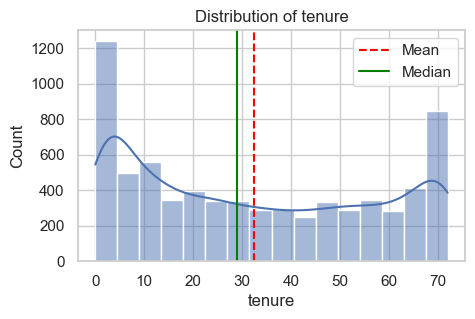

In [74]:
plot_histogram(df,"tenure")

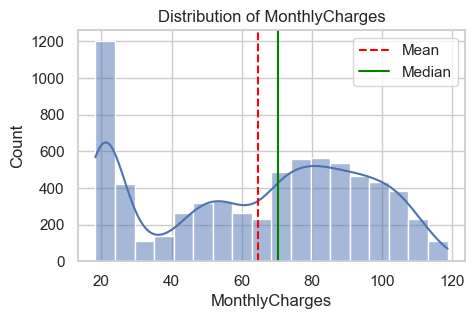

In [75]:
plot_histogram(df,"MonthlyCharges")

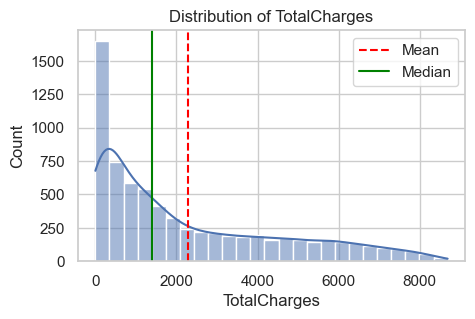

In [76]:
plot_histogram(df,"TotalCharges")

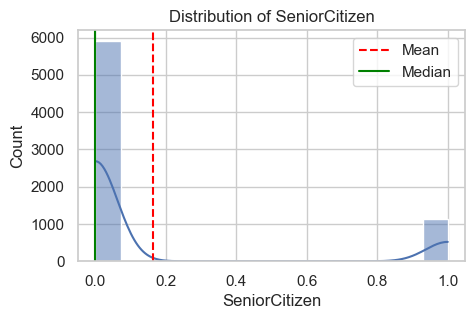

In [77]:
plot_histogram(df,"SeniorCitizen")

In [78]:
def plot_boxplot(df, column_name):

  plt.figure(figsize=(5, 3))
  sns.boxplot(y=df[column_name])
  plt.title(f"Box Plot of {column_name}")
  plt.ylabel(column_name)
  plt.show

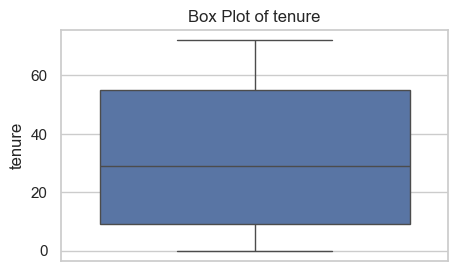

In [79]:
plot_boxplot(df, "tenure")

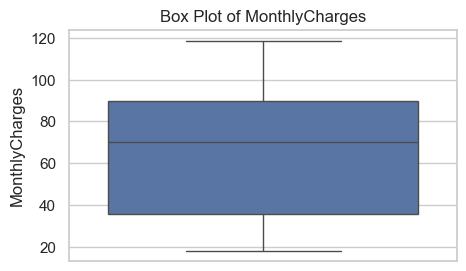

In [80]:
plot_boxplot(df, "MonthlyCharges")

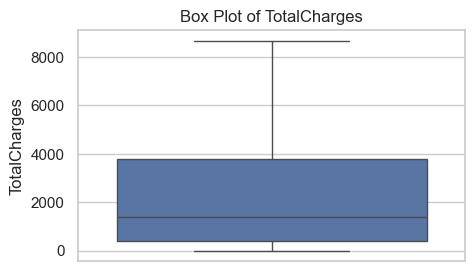

In [81]:
plot_boxplot(df, "TotalCharges")

Check for the correlation with the target columns

In [82]:
df['ChurnNumeric'] = df['Churn'].map({'No': 0, 'Yes': 1})

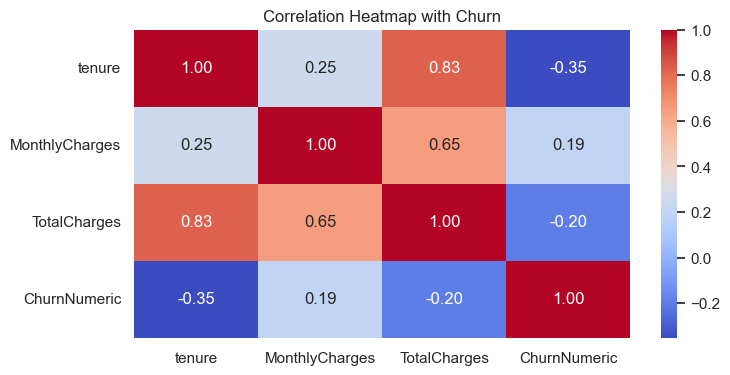

In [83]:
plt.figure(figsize=(8, 4))
sns.heatmap(
    df[['tenure', 'MonthlyCharges', 'TotalCharges', 'ChurnNumeric']].corr(),
    annot=True, cmap="coolwarm", fmt=".2f"
)
plt.title("Correlation Heatmap with Churn")
plt.show()

Categorical Feature Analysis

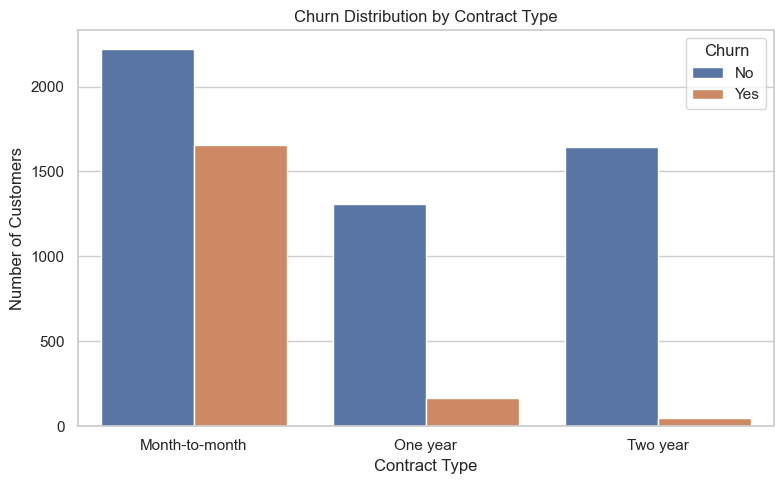

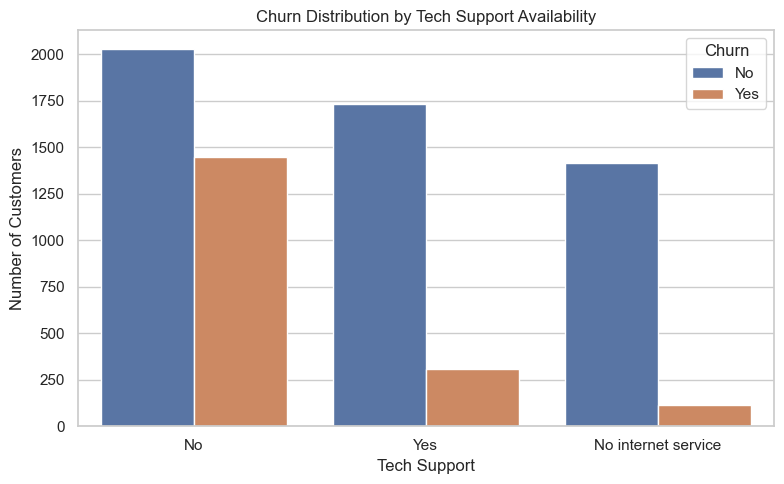

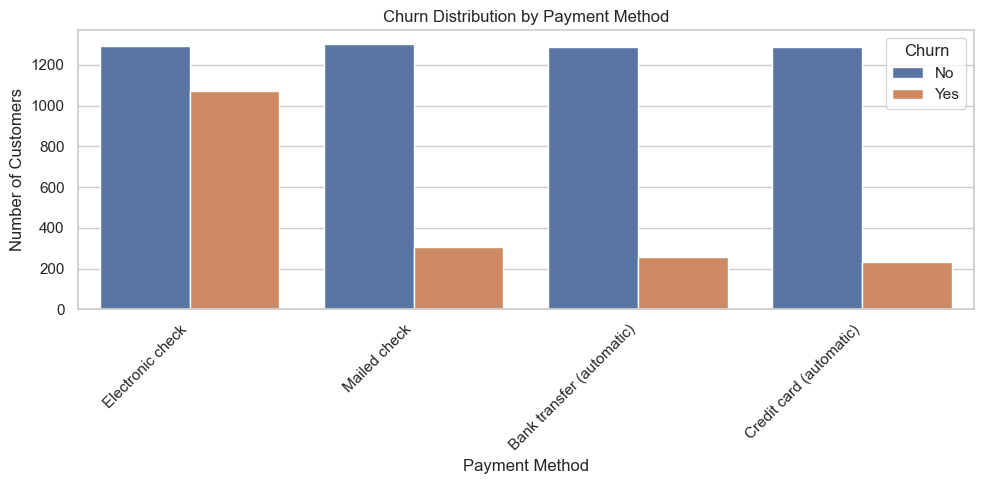

In [84]:
# Set visual style
sns.set(style="whitegrid")

# ============================
# 1. Contract vs Churn
# ============================
plt.figure(figsize=(8, 5))
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title('Churn Distribution by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Number of Customers')
plt.legend(title='Churn', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()

# ============================
# 2. Tech Support vs Churn
# ============================
plt.figure(figsize=(8, 5))
sns.countplot(x='TechSupport', hue='Churn', data=df)
plt.title('Churn Distribution by Tech Support Availability')
plt.xlabel('Tech Support')
plt.ylabel('Number of Customers')
plt.legend(title='Churn', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()

# ============================
# 3. Payment Method vs Churn
# ============================
plt.figure(figsize=(10, 5))
sns.countplot(x='PaymentMethod', hue='Churn', data=df)
plt.title('Churn Distribution by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Churn', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()

Class Imbalance Distribution

Churn
No     5174
Yes    1869
Name: count, dtype: int64


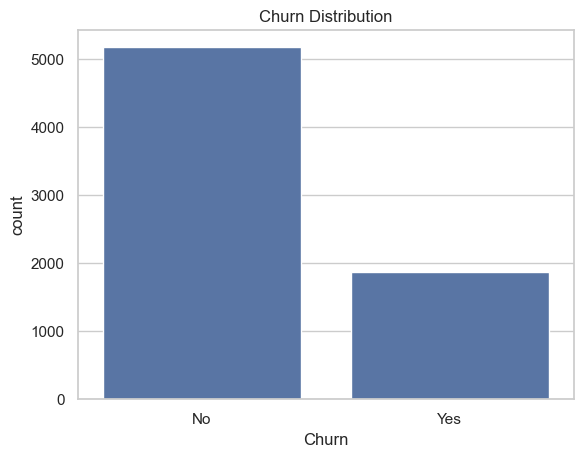

In [85]:
churn_counts = df['Churn'].value_counts()
print(churn_counts)
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()

Feature Distribution: Churned vs Non-Churned Customers

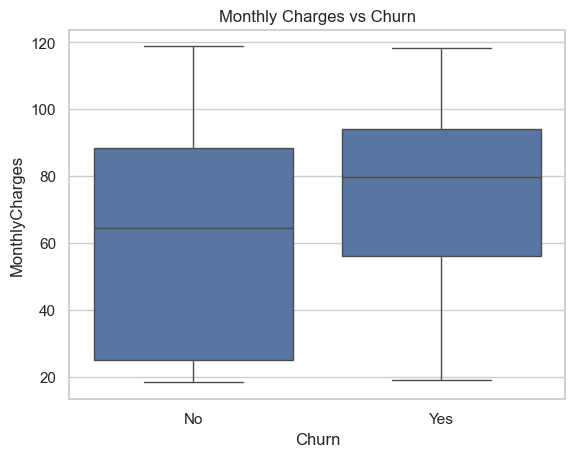

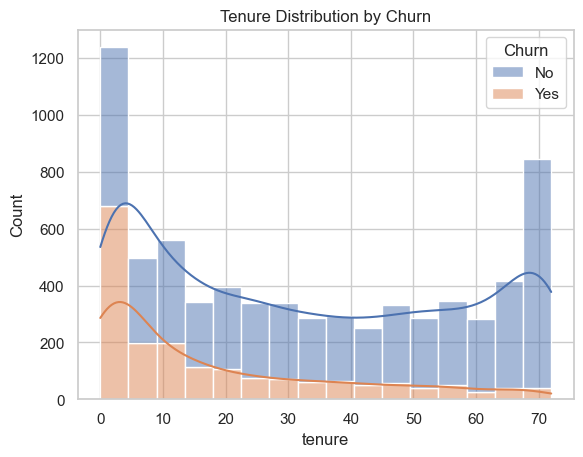

In [86]:
# Compare MonthlyCharges across churn
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Monthly Charges vs Churn')
plt.show()

# Tenure vs Churn
sns.histplot(data=df, x='tenure', hue='Churn', multiple='stack', kde=True)
plt.title('Tenure Distribution by Churn')
plt.show()

**Feature Engineering**

1. EngagementScore: Derived from MonthlyCharges, tenure and Tech_support. This column acts as a composite indicator of loyalty and   usage. A higher score likely means more engaged customers, i.e. Customers are less prone to churn.

2. CustomerInteractionFrequency: Derived from TechSupport. This column is used to measure the customer touchpoints, the fewer interactions, the more likely a customer leave silently.

3. LongTermContractStatbility: Derived from Contract. This columns captured the commitment level of a customer, longer the contrac lesser possibility of churn.

In [87]:
alpha, beta, gamma = 0.4, 0.3, 0.3
tech_map = {'Yes': 1, 'No': 0, 'No internet service': 0}
df['EngagementScore'] = alpha * df['MonthlyCharges'] + beta * df['tenure'] + gamma * df['TechSupport'].map(tech_map)
df['CustomerInteractionFrequency'] = df['TechSupport'].map(tech_map)
df['LongTermContractStability'] = df['Contract'].map({'Month-to-month': 0, 'One year': 1, 'Two year': 1})

In [88]:
df['EngagementScore'].unique()

array([12.24, 32.98, 22.14, ..., 61.28, 28.16, 30.06], shape=(3678,))

In [89]:
df['CustomerInteractionFrequency'].unique()

array([0, 1])

In [90]:
df['LongTermContractStability'].unique()

array([0, 1])

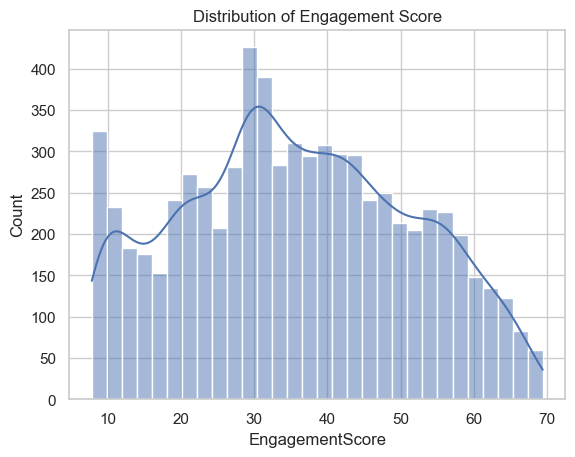

C:\Users\DELL\AppData\Local\Temp\ipykernel_17704\3675355576.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['Churn'] == 'Yes']['EngagementScore'], label='Churn', shade=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_17704\3675355576.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['Churn'] == 'No']['EngagementScore'], label='No Churn', shade=True)


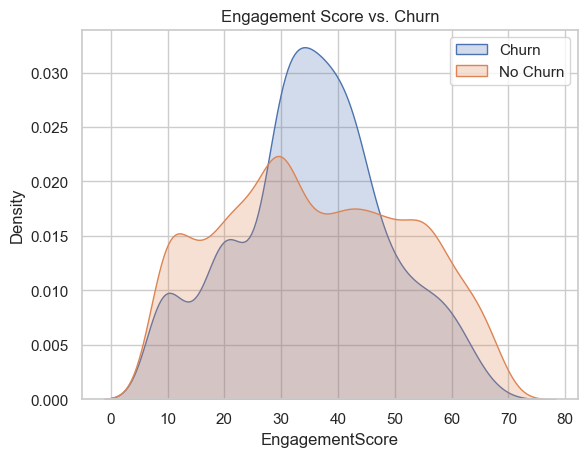

In [91]:
import seaborn as sns
sns.histplot(df['EngagementScore'], bins=30, kde=True)
plt.title("Distribution of Engagement Score")
plt.show()

# KDE Plot of Engagement Score by Churn
sns.kdeplot(df[df['Churn'] == 'Yes']['EngagementScore'], label='Churn', shade=True)
sns.kdeplot(df[df['Churn'] == 'No']['EngagementScore'], label='No Churn', shade=True)
plt.title("Engagement Score vs. Churn")
plt.legend()
plt.show()

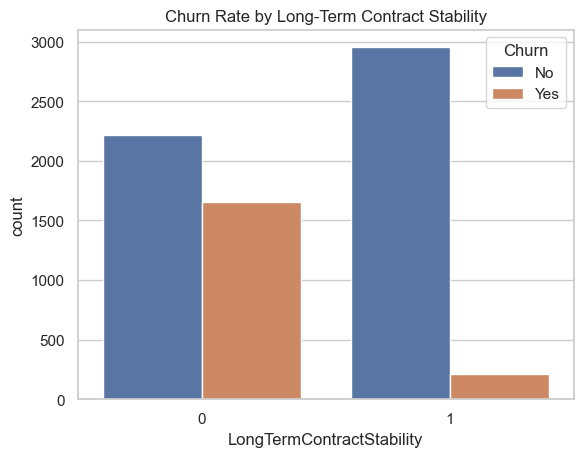

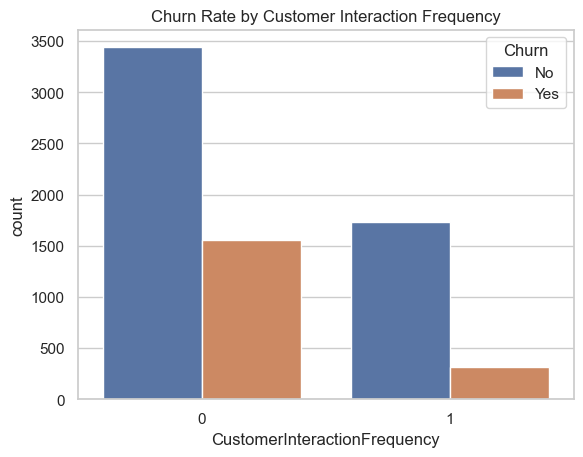

In [92]:
sns.countplot(x='LongTermContractStability', hue='Churn', data=df)
plt.title("Churn Rate by Long-Term Contract Stability")
plt.show()

# Countplot for Customer Interaction Frequency vs. Churn
sns.countplot(x='CustomerInteractionFrequency', hue='Churn', data=df)
plt.title("Churn Rate by Customer Interaction Frequency")
plt.show()

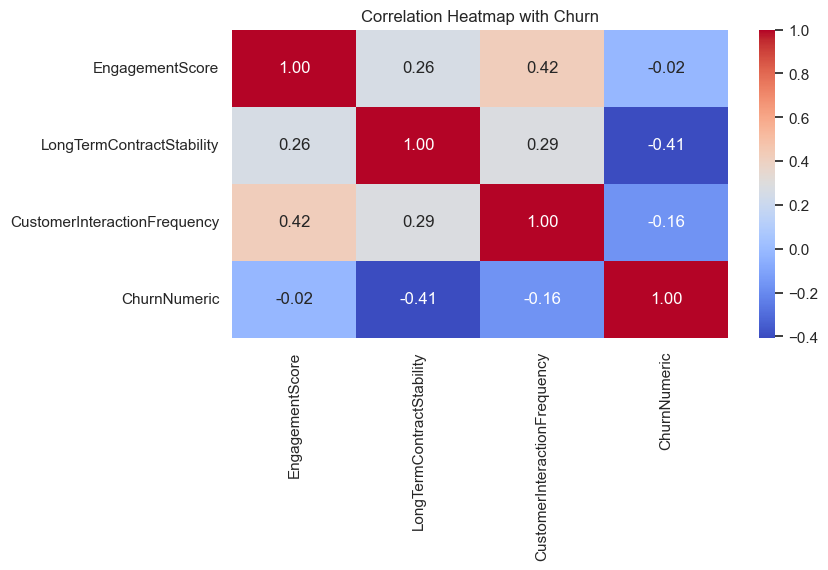

In [93]:
plt.figure(figsize=(8, 4))
sns.heatmap(
    df[["EngagementScore", "LongTermContractStability", 
        "CustomerInteractionFrequency", "ChurnNumeric"]].corr(),
    annot=True, cmap="coolwarm", fmt=".2f"
)
plt.title("Correlation Heatmap with Churn")
plt.show()

***Data Preprocessing and Train-Test Split***

In [94]:
df["Churn"] = df["Churn"].replace({"Yes": 1, "No": 0})

C:\Users\DELL\AppData\Local\Temp\ipykernel_17704\2364848822.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Churn"] = df["Churn"].replace({"Yes": 1, "No": 0})


In [95]:
features = ["EngagementScore", "CustomerInteractionFrequency", "LongTermContractStability"]
X = df[features]
y = df['Churn']

In [96]:
# Identify categorical columns
categorical_cols = []
numerical_cols = ["EngagementScore", "CustomerInteractionFrequency", "LongTermContractStability"]

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)  #  stratify

In [98]:
X_train.shape

(5634, 3)

In [99]:
X_test.shape

(1409, 3)

In [100]:
y_train.shape

(5634,)

In [101]:
y_test.shape

(1409,)

In [102]:
print(y_train.value_counts())

Churn
0    4139
1    1495
Name: count, dtype: int64


In [103]:
# 1. Separate numeric and categorical columns
numerical_cols = ["EngagementScore", "CustomerInteractionFrequency", "LongTermContractStability"]
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# 2. Encoding only (no scaling yet)
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')  # Keep numeric columns as-is

X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

Applying Synthetic Minority Oversampling Technique (SMOTE) to balance the imbalanced data

In [104]:
smote = SMOTE(sampling_strategy='auto', random_state=None, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("Class Distribution after SMOTE:\n", pd.Series(y_train_smote).value_counts())

Class Distribution after SMOTE:
 Churn
0    4139
1    4139
Name: count, dtype: int64


In [105]:
scaler = StandardScaler(with_mean=False)  # with_mean=False for sparse matrices
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test_encoded)

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


***Modelling**

In [106]:
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Cross-validation and scoring
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = ["accuracy", "precision", "recall", "f1", "roc_auc"]
results = {}

# Evaluate each model
for model_name, model in models.items():
    print(f"\nTraining {model_name} with default parameters...")
    model_scores = {}
    
    for metric in scoring_metrics:
        score = cross_val_score(model, X_train_scaled, y_train_smote, cv=cv, scoring=metric)
        mean_score = np.mean(score)
        model_scores[metric] = mean_score
        print(f"{metric.capitalize()}: {mean_score:.4f}")
    
    results[model_name] = model_scores
    print("-" * 70)


results_df = pd.DataFrame(results).T.sort_values(by="f1", ascending=False)
display(results_df.style.highlight_max(axis=0, color='lightgreen'))


Training Random Forest with default parameters...
Accuracy: 0.7269
Precision: 0.7235
Recall: 0.7347
F1: 0.7290
Roc_auc: 0.8021
----------------------------------------------------------------------

Training Logistic Regression with default parameters...
Accuracy: 0.7382
Precision: 0.6830
Recall: 0.8891
F1: 0.7725
Roc_auc: 0.7902
----------------------------------------------------------------------

Training Decision Tree with default parameters...
Accuracy: 0.7143
Precision: 0.7293
Recall: 0.6818
F1: 0.7047
Roc_auc: 0.7283
----------------------------------------------------------------------

Training Gradient Boosting with default parameters...
Accuracy: 0.7534
Precision: 0.7095
Recall: 0.8584
F1: 0.7768
Roc_auc: 0.8156
----------------------------------------------------------------------

Training XGBoost with default parameters...


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:56:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:56:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:56:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:56:16] WARNING: C:\actions-r

Accuracy: 0.7560


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:56:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:56:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:56:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:56:17] WARNING: C:\actions-r

Precision: 0.7262


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:56:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:56:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:56:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:56:18] WARNING: C:\actions-r

Recall: 0.8217


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:56:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:56:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:56:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:56:18] WARNING: C:\actions-r

F1: 0.7710


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:56:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:56:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:56:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:56:19] WARNING: C:\actions-r

Roc_auc: 0.8189
----------------------------------------------------------------------


,accuracy,precision,recall,f1,roc_auc
Gradient Boosting,0.753442,0.709495,0.858422,0.776775,0.815615
Logistic Regression,0.738221,0.683029,0.889105,0.772540,0.790171
XGBoost,0.755978,0.726250,0.821699,0.771002,0.818850
Random Forest,0.726866,0.723503,0.734722,0.728975,0.802063
Decision Tree,0.714302,0.729300,0.681808,0.704700,0.728273


In [107]:

results_df = pd.DataFrame(results).T.sort_values(by="f1", ascending=False)
print("\nModel Comparison Summary (Sorted by F1-score):")
print(results_df)


Model Comparison Summary (Sorted by F1-score):
                     accuracy  precision    recall        f1   roc_auc
Gradient Boosting    0.753442   0.709495  0.858422  0.776775  0.815615
Logistic Regression  0.738221   0.683029  0.889105  0.772540  0.790171
XGBoost              0.755978   0.726250  0.821699  0.771002  0.818850
Random Forest        0.726866   0.723503  0.734722  0.728975  0.802063
Decision Tree        0.714302   0.729300  0.681808  0.704700  0.728273


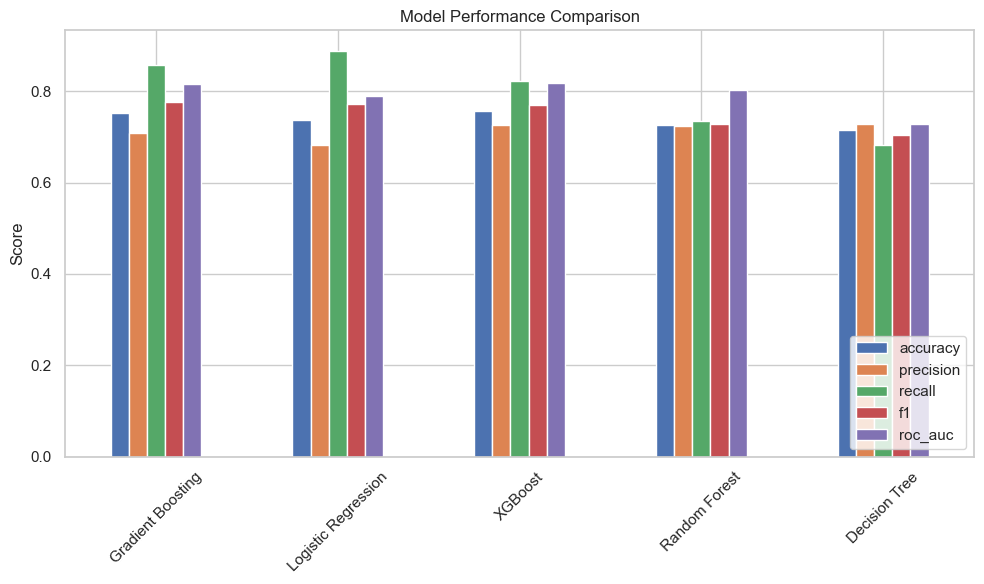

In [108]:
# Plot comparison
results_df.plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(loc='lower right')
plt.show()

In [109]:
# Final model (best performing)
best_model_name = results_df.index[0]
best_model = models[best_model_name]
best_model

GradientBoostingClassifier(random_state=42)

In [110]:
final_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', best_model)
])
final_pipeline.fit(X, y)
y_pred = final_pipeline.predict(X)
print(f"\nClassification Report for {best_model_name}:")
print(classification_report(y, y_pred))


Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.91      0.68      0.78      5174
           1       0.48      0.82      0.60      1869

    accuracy                           0.72      7043
   macro avg       0.70      0.75      0.69      7043
weighted avg       0.80      0.72      0.73      7043



In [111]:
import joblib

with open("best_churn_model_scaled.pkl", "wb") as f:
    joblib.dump(best_model, f)

In [112]:
# Save model for web app
import joblib
joblib.dump(final_pipeline, 'best_churn_model.pkl')

['best_churn_model.pkl']

In [113]:
with open("best_churn_model.pkl", "rb") as f:
    loaded_model = joblib.load(f)

In [114]:
final_pipeline

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index([], dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', GradientBoostingClassifier(random_state=42))])

GradientBoost as best model

In [115]:
gbc = GradientBoostingClassifier(n_estimators=200, learning_rate=0.01, max_depth=5, random_state=42)
gbc.fit(X_train_scaled, y_train_smote)

GradientBoostingClassifier(learning_rate=0.01, max_depth=5, n_estimators=200,
                           random_state=42)

In [116]:
y_test.value_counts()

Churn
0    1035
1     374
Name: count, dtype: int64

***Model Evaluation***

In [117]:
y_test_pred = gbc.predict(X_test_scaled)

print("Accuracy Score:\n", accuracy_score(y_test, y_test_pred))
print("Confsuion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Accuracy Score:
 0.6834634492547906
Confsuion Matrix:
 [[672 363]
 [ 83 291]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.65      0.75      1035
           1       0.44      0.78      0.57       374

    accuracy                           0.68      1409
   macro avg       0.67      0.71      0.66      1409
weighted avg       0.77      0.68      0.70      1409



In [118]:
df.head(10)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ChurnNumeric,EngagementScore,CustomerInteractionFrequency,LongTermContractStability
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,Month-to-month,Yes,Electronic check,29.85,29.85,0,0,12.24,0,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,One year,No,Mailed check,56.95,1889.50,0,0,32.98,0,1
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,Month-to-month,Yes,Mailed check,53.85,108.15,1,1,22.14,0,0
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,One year,No,Bank transfer (automatic),42.30,1840.75,0,0,30.72,1,1
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,Month-to-month,Yes,Electronic check,70.70,151.65,1,1,28.88,0,0
5,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,...,Month-to-month,Yes,Electronic check,99.65,820.50,1,1,42.26,0,0
6,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,...,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,0,0,42.24,0,0
7,Female,0,No,No,10,No,No phone service,DSL,Yes,No,...,Month-to-month,No,Mailed check,29.75,301.90,0,0,14.90,0,0
8,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,...,Month-to-month,Yes,Electronic check,104.80,3046.05,1,1,50.62,1,0
9,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,...,One year,No,Bank transfer (automatic),56.15,3487.95,0,0,41.06,0,1


In [119]:
churn1 = pd.DataFrame([[17.24, 0, 0]], columns=["EngagementScore", "CustomerInteractionFrequency", "LongTermContractStability"])
churn2 = pd.DataFrame([[30.96, 1, 0]], columns=["EngagementScore", "CustomerInteractionFrequency", "LongTermContractStability"])
churn3 = pd.DataFrame([[42.26, 1, 1]], columns=["EngagementScore", "CustomerInteractionFrequency", "LongTermContractStability"])
churn4 = pd.DataFrame([[10.26, 1, 0]], columns=["EngagementScore", "CustomerInteractionFrequency", "LongTermContractStability"])

In [120]:
churnpred1 = loaded_model.predict(churn1)
churnpred2 = loaded_model.predict(churn2)
churnpred3 = loaded_model.predict(churn3)
churnpred4 = loaded_model.predict(churn4)

print("Churn Prediction 1:", churnpred1[0])
print("Churn Prediction 2:", churnpred2[0])
print("Churn Prediction 3:", churnpred3[0])
print("Churn Prediction 4:", churnpred4[0])

Churn Prediction 1: 1
Churn Prediction 2: 1
Churn Prediction 3: 0
Churn Prediction 4: 0


In [121]:
print(f"Prediction: {'Churn' if churnpred4[0] == 1 else 'No Churn'}")
print(f"Prediciton Probability: {churnpred4}")

Prediction: No Churn
Prediciton Probability: [0]


In [122]:
model = joblib.load("best_churn_model.pkl") 
churn_test = pd.DataFrame([[12.0, 0, 0]], columns=["EngagementScore", "CustomerInteractionFrequency", "LongTermContractStability"])
proba = model.predict_proba(churn_test)[0][1]
print(f"Churn probability: {proba:.2%}")

Churn probability: 47.11%
